In [2]:
%matplotlib inline

In [3]:
from math import pi
from scipy.linalg import hadamard
from scipy.signal.windows import dpss
from matplotlib import pyplot as plt
from scipy.optimize import minimize, LinearConstraint

# pennylane/autgrad numpy
import pennylane.numpy as np
import pennylane as qml

#### hacked pennylane code
# new single qubit op
from pennylane.ops.qubit import RotXY
# modified device to support RotXY
from pennylane import device 
# modified template with RotXY as op
from pennylane.templates.layers import StronglyEntanglingLayersRotXY

# the og
import numpy as onp

In [4]:
# define some observables 
obs = [
  qml.PauliZ(1),
  qml.PauliX(0) @ qml.PauliX(1)
]

In [91]:
def se_circuit(num_wires, num_layers, obs):
    # Instantiate a StronglyEntanglingCircuit
    
    # num layers must be power of 2 for Walsh/Hadamard basis
    # TODO: add check

    dev = qml.device("default.qubit", wires=num_wires, analytic=True)

    # Map our ansatz over our list of observables,
    qnodes = qml.map(StronglyEntanglingLayersRotXY, obs, device=dev)

    theta_tape = onp.random.rand(num_layers,num_wires,2)
    # choose a circuit/obs from qnodes list
    circ = qnodes[-1]
    circ(theta_tape)
    
    return circ

In [85]:
# GRAFS functions

def grafs_circuit(_alpha, _circuit, _V):
    # transform global (alpha) --> local (theta)
    theta_ = onp.tensordot(_V,_alpha,([1],[0]))
    # evaluate the circuit
    return _circuit(theta_)

def grafs_grad(_alpha, _circuit, _V):
    # alpha --> theta
    theta_ = onp.tensordot(_V,_alpha,([1],[0]))
    # compute gradient wrt theta with pennylane/autograd
    cc = qml.grad(_circuit)(theta_)[0]
    # complete the chain-rule to get gradient wrt alpha
    return onp.tensordot(_V,cc,([0],[0]))

def grafs_step(_alpha, _circuit,_lr):
    # gradient step in function space
    return _alpha - _lr*grafs_grad(_alpha,_circuit)

In [93]:
def grafs_grad_variance(_circuit, _basis, num_samples=100):
    varz = []
    for _ in range(num_samples):
        alpha_sample = onp.random.rand(_basis.shape[1], _circuit.device.num_wires,2)
        # computer the variance of all components of the gradient
        var_sample = onp.var(grafs_grad(alpha_sample, _circuit, _basis))
        varz.append(var_sample)
    return varz

## Barren Plateaus 

In [109]:
num_layers = 2**7

# fix num basis functions
K = 10

### Compare Walsh ("discrete") vs Slepian ("smooth") bases

In [144]:
# Walsh/Hadamard basis functions 
Walsh = hadamard(num_layers)[:,:K]
#plt.plot(Walsh);

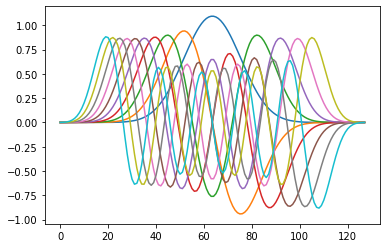

In [132]:
# dpss basis aka Slepians 
W = 0.075
NW = num_layers*W
#K = int(2*num_layers*W-1)

Slepians = 5.*dpss(num_layers,NW,K).T
plt.plot(Slepians);

In [126]:
variances_walsh = [] 
for num_wires in [2,3,4,5,6,7]:
    circuit = se_circuit(num_wires, num_layers, obs)
    variances_walsh.append(grafs_grad_variance(circuit,Walsh,50))

In [133]:
variances_slepian = [] 
for num_wires in [2,3,4,5,6,7]:
    circuit = se_circuit(num_wires, num_layers, obs)
    variances_slepian.append(grafs_grad_variance(circuit,Slepians,50))

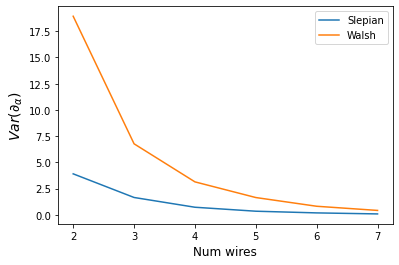

In [143]:
plt.plot([2,3,4,5,6,7], np.mean(np.array(variances_slepian),1), label='Slepian');
plt.plot([2,3,4,5,6,7], np.mean(np.array(variances_walsh),1), label='Walsh');
plt.xlabel('Num wires', fontsize=12)
plt.ylabel(r'$Var(\partial_\alpha)$', fontsize=14)
plt.legend();